# This project shows how deep learning can be applied to detect wafer failure

This dataset (WM-811K) wafermap is collected from 47,543 lots in real-world fab. However, not all lots have perfect 25 wafer maps and it may caused by sensor failure or other unknown problems. So we only have 811,457 wafer maps in total

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# import data
data = pd.read_pickle("/content/drive/MyDrive/Python 資料/Residual Network/LSWMD.pkl.zip (Unzipped Files)/LSWMD.pkl")

## Image Transformation

In [3]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
# drop wafer index, the variable we don't need (wafer index indiciate the lot of each wafer map)
df = data.drop(['waferIndex'], axis = 1)

### Missing label (faliure type) check

- 172,950 wafers have labels
  - 25,519 wafers have real failure patterns
  - 147,431 wafers were still labeled none
- 638,507 wafers have no labels

In [5]:

# First, we can label encoding the obj into int, so the job can be done esily
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df

/usr/local/lib/python3.7/dist-packages/pandas/core/array_algos/replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],2,1
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],3,1
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,[],[],[],[]


In [6]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

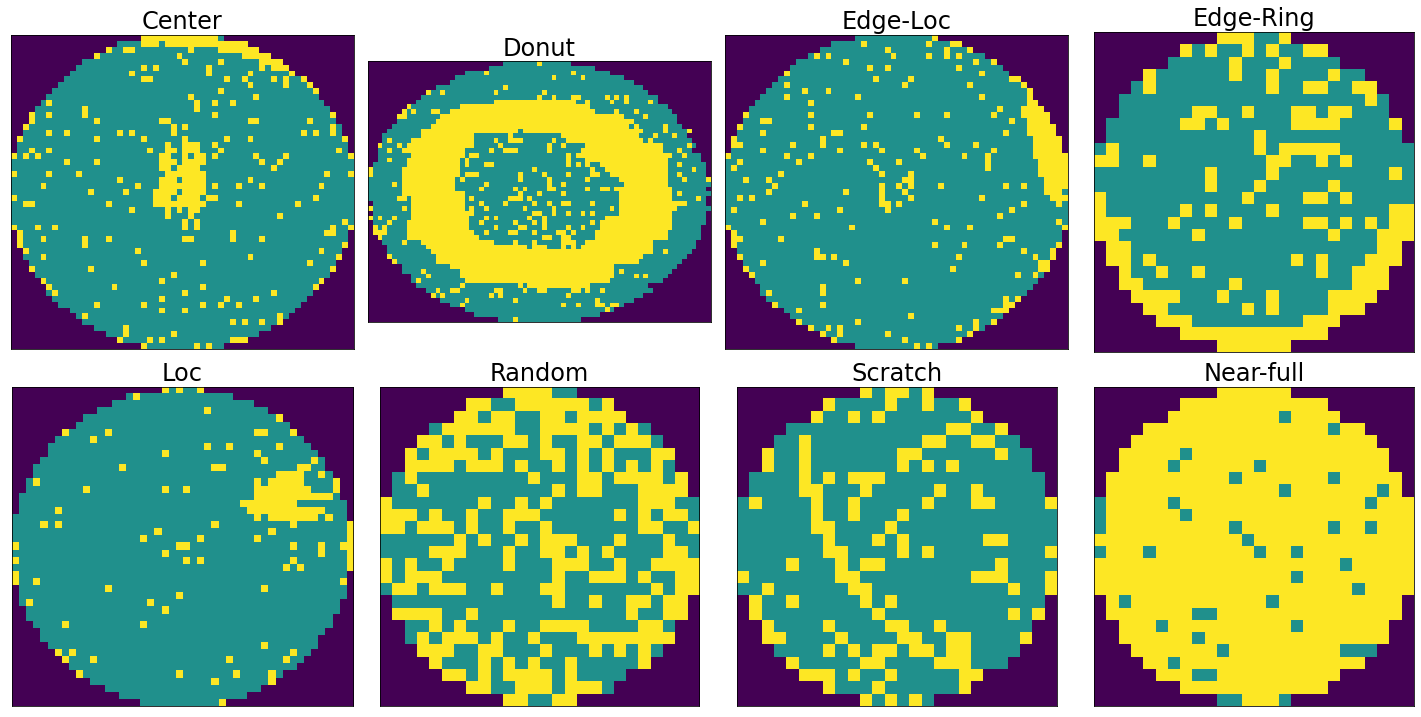

In [7]:
# Failure pattern visualization

x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']


fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

### Dimension Check

We found that each image has different dimension and this could be a problem for classifcation!
Therefore, we need to transform image size to make the input the same dimension

In [8]:
def find_dim(x):
    return x.shape[0], x.shape[1]
df_withpattern['waferMapDim'] = df_withpattern.waferMap.apply(find_dim)
df_withpattern.sample(5)

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
14434,529852,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot33169,[[Training]],[[Center]],0,0,"(25, 27)"
7218,229755,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5815.0,lot14395,[[Training]],[[Edge-Ring]],3,0,"(100, 72)"
13083,385427,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1658.0,lot23110,[[Training]],[[Edge-Ring]],3,0,"(46, 46)"
3566,141197,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3927.0,lot9146,[[Training]],[[Edge-Ring]],3,0,"(69, 73)"
21634,745983,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",518.0,lot44883,[[Training]],[[Edge-Loc]],2,0,"(27, 25)"


In [9]:
# difference between largest and smallest image
max(df_withpattern.waferMapDim), min(df_withpattern.waferMapDim)

((212, 84), (22, 35))

In [10]:
# check the most common image dimension
df_withpattern['waferMapDim'].value_counts()

(25, 27)    2900
(38, 36)    2127
(53, 52)    1519
(63, 62)    1424
(39, 37)    1015
            ... 
(63, 63)       1
(41, 39)       1
(53, 44)       1
(50, 68)       1
(42, 39)       1
Name: waferMapDim, Length: 329, dtype: int64

### Resize Image

In [11]:
import cv2

def resize_image(image):
  '''resize image to 25*27 (the most commone dimension)'''
  resize_image = cv2.resize(image, (27, 25), interpolation=cv2.INTER_AREA)
  return resize_image
X = list()

for i in df_withpattern['waferMap']:
  if i.shape != (25, 27):
    image = resize_image(i)
    X.append(image)
  else:
    X.append(i)

X = np.array(X).astype(np.float32)
Y = pd.get_dummies(df_withpattern['failureNum']).astype(np.float32).values


In [12]:
a = df_withpattern['waferMap'][0]
b = cv2.resize(a, (25, 27), interpolation=cv2.INTER_AREA)

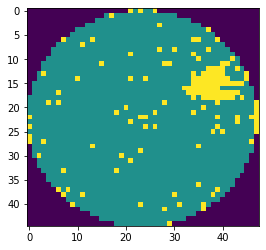

In [13]:
plt.imshow(a)

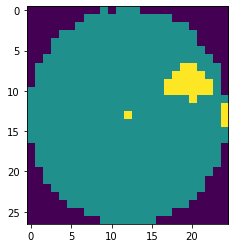

In [14]:
plt.imshow(b)

## CNN

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPool2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten

In [16]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(X,Y, test_size=0.3, random_state=1)

In [25]:
model = Sequential([
    
   Conv2D(filters=30, kernel_size=(3,3), kernel_initializer='he_uniform',input_shape=(25,27,1), activation = 'relu', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   
   Flatten(),
   Dense(units=1024, activation='relu', name="hidden_layer1"),
   
   Dense(units=1024, activation='relu', name="hidden_layer2"),
   Dense(units = y_train.shape[1], activation = 'softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 25, 27, 30)        300       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 13, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 13, 30)        8130      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 30)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 30)        

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training_records = model.fit(
    x_train, y_train, batch_size=10, epochs=30, verbose=1,
    validation_data = (x_test, y_test)
)

Epoch 1/30
1787/1787 [==============================] - 12s 6ms/step - loss: 0.7495 - accuracy: 0.7190 - val_loss: 0.5702 - val_accuracy: 0.7870
Epoch 2/30
1787/1787 [==============================] - 10s 6ms/step - loss: 0.5085 - accuracy: 0.8107 - val_loss: 0.6099 - val_accuracy: 0.7607
Epoch 3/30
1787/1787 [==============================] - 9s 5ms/step - loss: 0.4258 - accuracy: 0.8373 - val_loss: 0.5204 - val_accuracy: 0.8188
Epoch 4/30
1787/1787 [==============================] - 11s 6ms/step - loss: 0.3807 - accuracy: 0.8540 - val_loss: 0.3938 - val_accuracy: 0.8557
Epoch 5/30
1787/1787 [==============================] - 10s 6ms/step - loss: 0.3500 - accuracy: 0.8644 - val_loss: 0.3847 - val_accuracy: 0.8626
Epoch 6/30
1787/1787 [==============================] - 10s 6ms/step - loss: 0.3242 - accuracy: 0.8738 - val_loss: 0.4046 - val_accuracy: 0.8544
Epoch 7/30
1787/1787 [==============================] - 9s 5ms/step - loss: 0.2959 - accuracy: 0.8850 - val_loss: 0.3942 - val_accu